In [1]:
import argparse
from os import listdir, makedirs
from os.path import isdir

import cv2
import numpy as np
from matplotlib.pyplot import imshow

NORM_W = 2688
NORM_H = 1520
THERM_W = 1280
THERM_H = 720
NORM_BOX_X = 650
NORM_BOX_Y = 131
THERM_BOX_X = 33
THERM_BOX_Y = 18
NORM_BOX_W = 1657
NORM_BOX_H = 1262
THERM_BOX_W = 1211
THERM_BOX_H = 688

SCALE_W = NORM_W / THERM_W
SCALE_H = NORM_H / THERM_H
NORM_CENTRE_X = NORM_W / 2
NORM_CENTRE_Y = NORM_H / 2
THERM_CENTRE_X = THERM_W / 2
THERM_CENTRE_Y = THERM_H / 2
NORM_BOX_CENTRE_X = NORM_BOX_W / 2 + NORM_BOX_X
NORM_BOX_CENTRE_Y = NORM_BOX_H / 2 + NORM_BOX_Y
THERM_BOX_CENTRE_X = THERM_BOX_W / 2 + THERM_BOX_X
THERM_BOX_CENTRE_Y = THERM_BOX_H / 2 + THERM_BOX_Y

THERM_BOX_SCALED_CENTRE_X = THERM_BOX_CENTRE_X * SCALE_W
THERM_BOX_SCALED_CENTRE_Y = THERM_BOX_CENTRE_Y * SCALE_H
BOX_CENTRE_OFFSET_X = NORM_BOX_CENTRE_X - THERM_BOX_SCALED_CENTRE_X
BOX_CENTRE_OFFSET_Y = NORM_BOX_CENTRE_Y - THERM_BOX_SCALED_CENTRE_Y
SCALE_BOX_W = NORM_BOX_W / (THERM_BOX_W * SCALE_W)
SCALE_BOX_H = NORM_BOX_H / (THERM_BOX_H * SCALE_H)

In [2]:
def frame_to_annotation(src, frame, dest):
    """
    Generate YOLO-compliant label from thermal image to apply to the corresponding optical image
    """
    img = cv2.imread(f'{src}/{frame}', 0)

    blur = cv2.GaussianBlur(img, (5, 5), 0)
    ret, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Generate intermediate image; use morphological closing to keep parts of the cow together
    inter = cv2.morphologyEx(th, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # Find 2 largest contours in intermediate image
    cnts, _ = cv2.findContours(inter, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = sorted(cnts, key=lambda c: cv2.contourArea(c), reverse=True)
    cnts = cnts[:2]

    # Output
    out = np.zeros(img.shape, np.uint8)
    cv2.drawContours(out, cnts, -1, 255, cv2.FILLED)
    out = cv2.bitwise_and(img, out)

    makedirs(f'{dest}/labels', exist_ok=True)
    with open(f'{dest}/labels/{frame.split(".")[0]}.txt', 'w') as text_file:
        for cnt in cnts:
            x, y, w, h = cv2.boundingRect(cnt)
            x, y, w, h = transform_bounding_rect(img, x, y, w, h)
            # Convert to proportion of image size
            x /= NORM_W
            y /= NORM_H
            w /= NORM_W
            h /= NORM_H
            text_file.write(f'0 {x} {y} {w} {h}\n')

In [3]:
def transform_bounding_rect(img, x, y, w, h):
    """
    Transform `x`, `y`, `w`, and `h` of a bounding rectangle drawn on a thermal image to match the corresponding optical image
    """

    # x, y, w, h * 2.1
    x = round(x * SCALE_W)
    y = round(y * SCALE_H)
    w = round(w * SCALE_W)
    h = round(h * SCALE_H)

    # x, y - centre
    x -= NORM_CENTRE_X
    y -= NORM_CENTRE_Y

    # x,y,w,h * box scale
    x = round(x * SCALE_BOX_W)
    y = round(y * SCALE_BOX_H)
    w = round(w * SCALE_BOX_W)
    h = round(h * SCALE_BOX_H)

    # x, y - centre
    x = round(x + NORM_CENTRE_X)
    y = round(y + NORM_CENTRE_Y)

    # x, y + box centre offset
    x += round(BOX_CENTRE_OFFSET_X)
    y += round(BOX_CENTRE_OFFSET_Y)

    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 10)
    imshow(img)

    return x, y, w, h

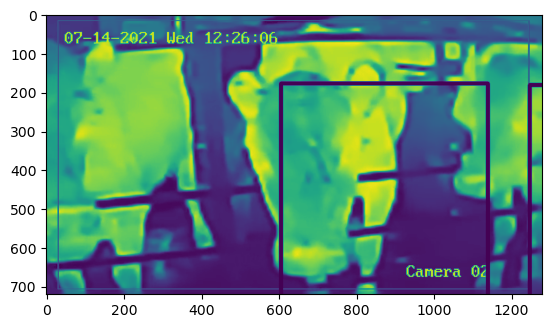

In [4]:
frames = sorted((f for f in listdir("/Users/adam/Git/agricam/data/video/clean thermal/therm/frames") if not (f.startswith(".") or isdir(f'{"/Users/adam/Git/agricam/data/video/clean thermal/therm/frames"}/{f}'))), key=str.lower)
for i, frame in enumerate(frames):
    frame_to_annotation("/Users/adam/Git/agricam/data/video/clean thermal/therm/frames", frame, "/Users/adam/Git/agricam/data/video/clean thermal/therm/frames")